<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/shap_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

In [ ]:
N = 4000
X, y = make_classification(n_samples=N, n_features=2, 
                           n_informative=2, n_redundant=0, 
                           class_sep=0.5, random_state=0)

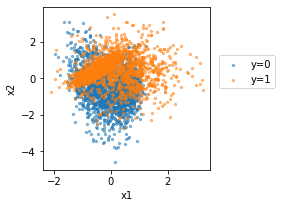

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(*X[y==0].T, alpha=0.5, s=5, label='y=0')
ax.scatter(*X[y==1].T, alpha=0.5, s=5, label='y=1')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend(loc=(1.05, 0.5))
plt.show()

Separate the data into three parts: 
1. The first part for model training
2. The second part is considered data from "Day 1"
3. The third part is considered data from "Day 2"

In [ ]:
K = int(N / 4)
X0, X1, X2 = X[:2*K], X[2*K:3*K], X[3*K:]
y0, y1, y2 = y[:2*K], y[2*K:3*K], y[3*K:]

In [ ]:
model = lgb.LGBMClassifier()
model.fit(X0, y0)

explainer = shap.TreeExplainer(model, data=X0[y0==0])

In [ ]:
def plot_scores(X1, X2, model):
    """
    """
    s1, s2 = model.predict_proba(X1)[:,1], model.predict_proba(X2)[:,1]
    y1, y2 = list(np.log(s1/(1-s1))), list(np.log(s2/(1-s2)))
    s1, s2 = list(s1), list(s2)

    fig, (ax1, ax2) = plt.subplots(figsize=(8,3), ncols=2)

    smin, smax = min(s1+s2), max(s1+s2)
    bins = np.linspace(smin, smax, 21)
    ax1.hist(s1, bins=bins, density=True, alpha=0.5, label='Day 1')
    ax1.hist(s2, bins=bins, density=True, alpha=0.5, label='Day 2')
    ax1.set_yticks([])
    ax1.legend()
    ax1.set_xlabel('Score')
    
    ymin, ymax = min(y1+y2), max(y1+y2)
    bins = np.linspace(ymin, ymax, 21)
    ax2.hist(y1, bins=bins, density=True, alpha=0.5, label='Day 1')
    ax2.hist(y2, bins=bins, density=True, alpha=0.5, label='Day 2')
    ax2.set_yticks([])
    ax2.legend()
    ax2.set_xlabel('Log(score / (1-score))')
    plt.show()

def plot_values(vals1, vals2, xlabel, xlim=None):
    """
    """
    fig, axs = plt.subplots(ncols=2, figsize=(8,3))
    for i, ax in enumerate(axs):
        x1 = vals1[:,i].tolist()
        x2 = vals2[:,i].tolist()
        xmin, xmax = min(x1+x2), max(x1+x2)
        bins = np.linspace(xmin, xmax, 21)
        ax.hist(x1, bins=bins, density=True, alpha=0.5, label='Day 1')
        ax.hist(x2, bins=bins, density=True, alpha=0.5, label='Day 2')
        ax.set_yticks([])
        ax.legend()
        ax.set_xlabel(xlabel % (i+1))
        if xlim is not None:
            ax.set_xlim(xlim)
    plt.show()

Because the data in "Day 1" and "Day 2" are *iid*, one can see that: 
* The score distribution are the same. 
* The feature value distribution of $x_1$ and $x_2$ are the same.
* The Shapley value distribution of $x_1$ and $x_2$ are the same.

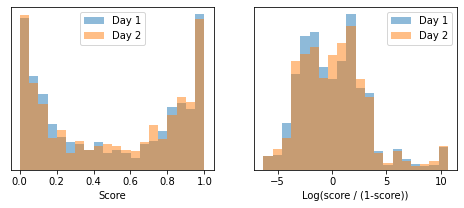

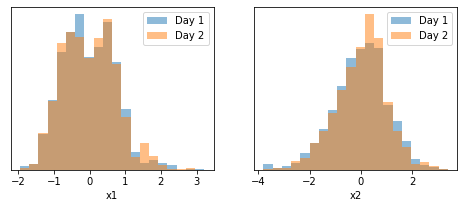

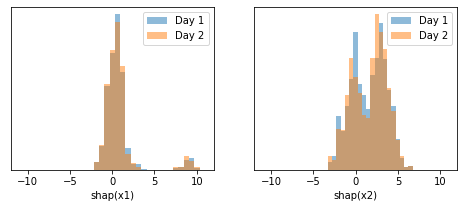

In [ ]:
svals1 = explainer.shap_values(X1)
svals2 = explainer.shap_values(X2)

plot_scores(X1, X2, model)
plot_values(X1, X2, xlabel='x%d')
plot_values(svals1, svals2, xlabel='shap(x%d)', xlim=(-12, 12))

Now change *only* the first feature $x_1$. 

One can see that: 
* The score distribution shifts. 
* The feature value distribution of $x_1$ shifts, but not for $x_2$. 
* The Shapley value distribution of $x_1$ shifts, but not as much for $x_2$. 

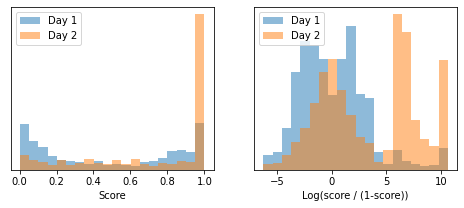

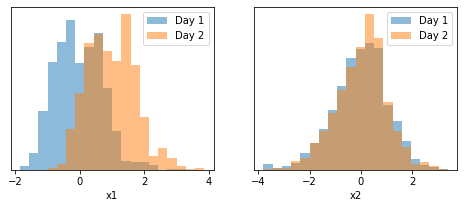

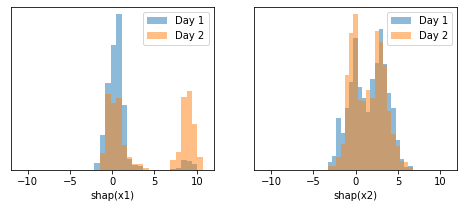

In [ ]:
X2[:, 0] = X2[:, 0] + 1

svals1 = explainer.shap_values(X1)
svals2 = explainer.shap_values(X2)

plot_scores(X1, X2, model)
plot_values(X1, X2, xlabel='x%d')
plot_values(svals1, svals2, xlabel='shap(x%d)', xlim=(-12, 12))